In [1]:
# Load Biospytial modules and etc.
%matplotlib inline
import sys
sys.path.append('/apps')
import django
django.setup()
import pandas as pd
import matplotlib.pyplot as plt
## Use the ggplot style
plt.style.use('ggplot')


In [2]:
data = pd.read_csv("/RawDataCSV/iDiv_data_share/plotsClimateData_11092017.csv")


/opt/conda/envs/biospytial/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (24) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [21]:
import geopandas as gpd

In [151]:
from django.contrib.gis import geos
from shapely.geometry import Point

In [179]:
data['geometry'] = data.apply(lambda z: Point(z.LON, z.LAT), axis=1)
new_data = gpd.GeoDataFrame(data)

## Let´s reproject to Alberts or something with distance

In [161]:
new_data.crs = {'init':'epsg:4326'}

In [162]:
new_data =  new_data.to_crs("+proj=aea +lat_1=29.5 +lat_2=45.5 +lat_0=37.5 +lon_0=-96 +x_0=0 +y_0=0 +ellps=GRS80 +datum=NAD83 +units=m +no_defs ")

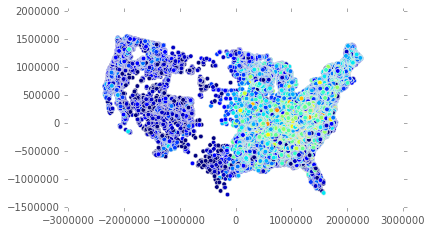

In [163]:
new_data.plot(column='SppN')

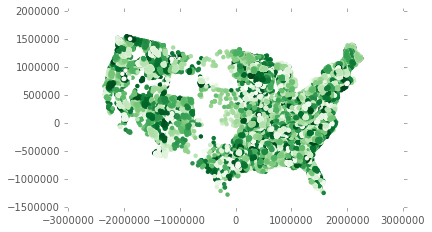

In [164]:
new_data.plot(cmap=plt.cm.Greens,edgecolors='')

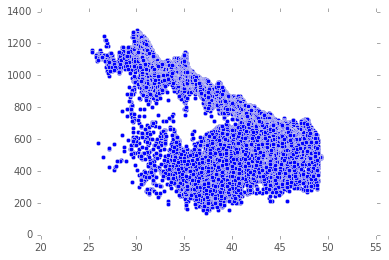

In [167]:
plt.scatter(new_data.lat,geodata.AET)

In [166]:
plt.scatter(.lon,geodata.AET)

SyntaxError: invalid syntax (<ipython-input-166-ec15e2f966fb>, line 1)

In [ ]:
plt.scatter(geodata.lon,geodata.plotBiomass)

## The area is very big -> 35000 points. 
We need to make a subset of this


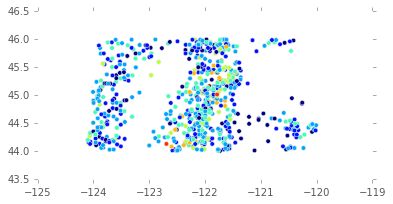

In [182]:
section = new_data[lambda x:  (x.LON < -120) & (x.LON > -125) & (x.LAT > 44) & (x.LAT < 46) ]
section.plot(column='SppN')

In [206]:
section.shape

(653, 44)

In [207]:
section['newLon'] = section.apply(lambda c : c.geometry.x, axis=1)
section['newLat'] = section.apply(lambda c : c.geometry.y, axis=1)

/opt/conda/envs/biospytial/lib/python2.7/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
/opt/conda/envs/biospytial/lib/python2.7/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


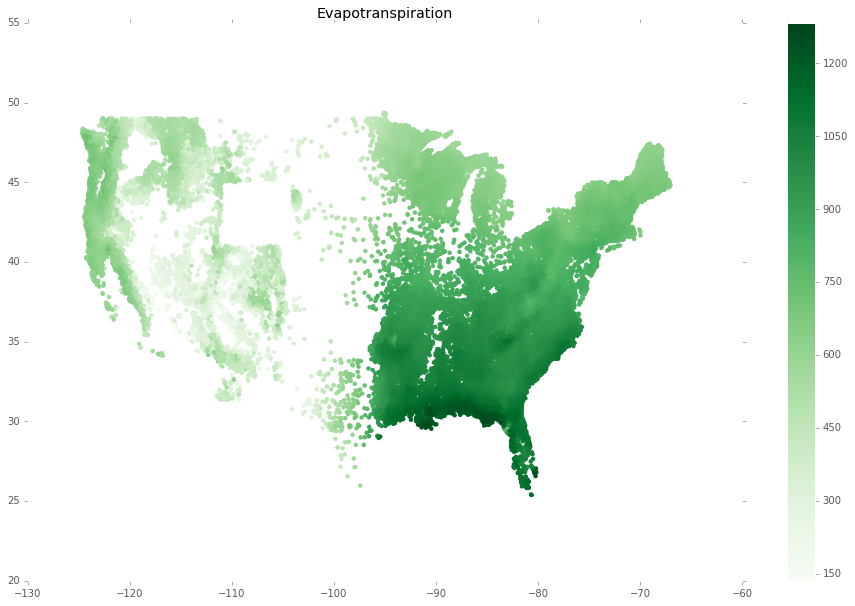

In [208]:

fig = plt.figure(figsize=(16,10), dpi= 80, facecolor='w', edgecolor='w')
plt.rcParams['axes.facecolor'] = 'white'
plt.scatter(data.lon,data.lat,c=data.AET,cmap=plt.cm.Greens,edgecolors='')
plt.title("Evapotranspiration")
plt.colorbar()

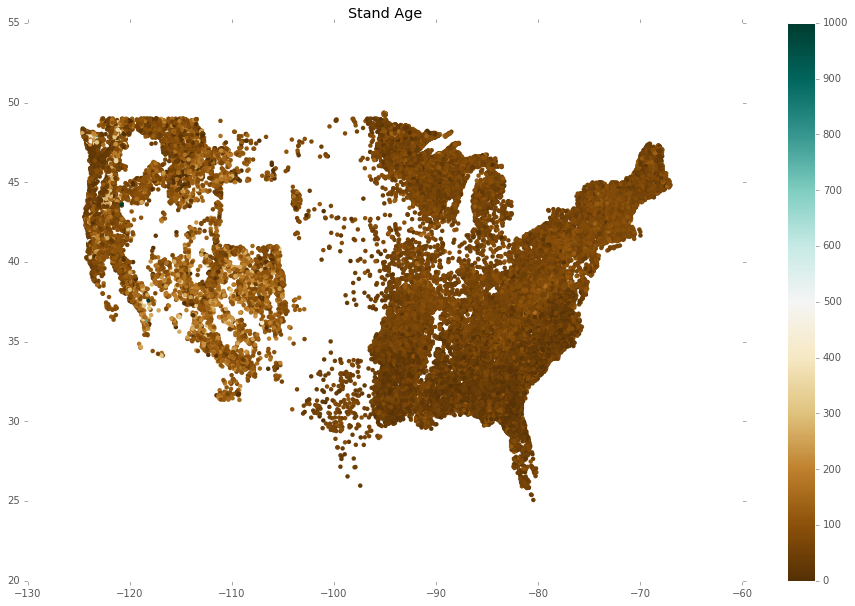

In [209]:
fig = plt.figure(figsize=(16,10), dpi= 80, facecolor='w', edgecolor='w')
plt.scatter(data.lon,data.lat,c=data.StandAge,edgecolors='',cmap=plt.cm.BrBG)
plt.title("Stand Age")
plt.colorbar()

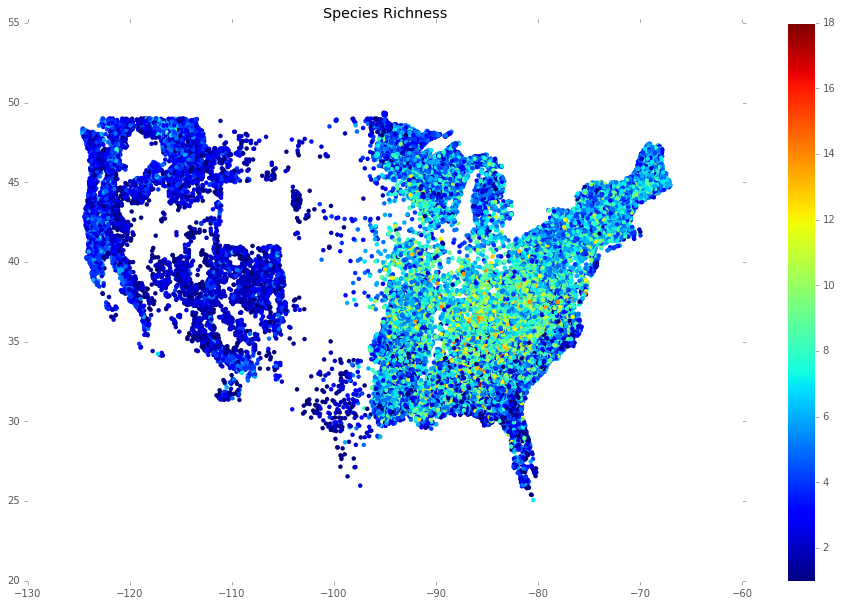

In [77]:
fig = plt.figure(figsize=(16,10), dpi= 80, facecolor='w', edgecolor='w')
plt.scatter(data.lon,data.lat,c=data.SppN,edgecolors='')
plt.title("Species Richness")
plt.colorbar()

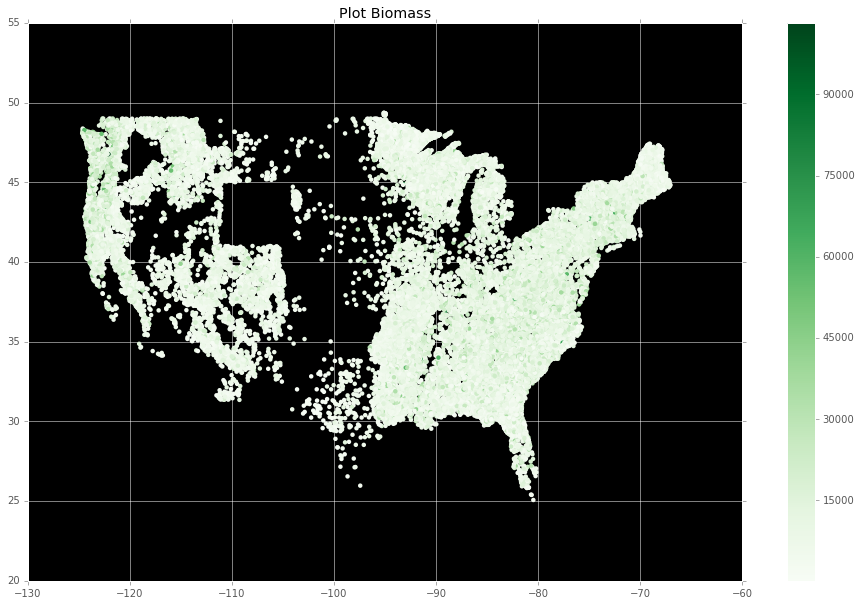

In [6]:
fig = plt.figure(figsize=(16,10), dpi= 80, facecolor='w', edgecolor='w')
plt.scatter(data.lon,data.lat,c=data.plotBiomass,edgecolors='',cmap=plt.cm.Greens)
plt.title("Plot Biomass")
plt.colorbar()

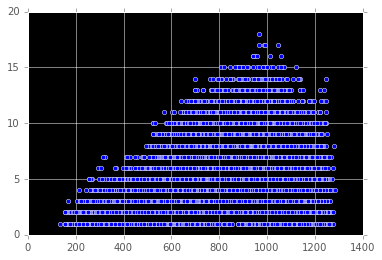

In [7]:
plt.scatter(data.AET,data.SppN)

# Model Fitting Using a GLM 
The general model will have the form:
$$ Biomass(x,y) = \beta_1 AET + \beta_2 Age + Z(x,y) + \epsilon $$
Where:
$\beta_1$ and $\beta_2$ are model parameters, $Z(x,y)$ is the *Spatial Autocorrelation* process and $\epsilon \sim N(0,\sigma^2)$

In [70]:
##### OLDY
len(data.lon)
#X = data[['AET','StandAge','lon','lat']]
X = data[['SppN','lon','lat']]
#X = data[['lon','lat']]
Y = data['plotBiomass']
#Y = data[['SppN']]
## First step in spatial autocorrelation
#Y = pd.DataFrame(np.zeros(len(Y)))
## Let´s take a small sample only for the spatial autocorrelation
import numpy as np
sample_size = 2000
randindx = np.random.randint(0,X.shape[0],sample_size)
nX = X.loc[randindx]
nY = Y.loc[randindx]


In [221]:
X = section[['newLon','newLat']]
#X = data[['lon','lat']]
Y = section['plotBiomass']
sample_size = Y.shape[0]

In [222]:
# Import GPFlow
import GPflow as gf
k = gf.kernels.Matern12(2, lengthscales=1, active_dims = [0,1] )

In [223]:
model = gf.gpr.GPR(X.as_matrix(),Y.as_matrix().reshape(sample_size,1).astype(float),k)

In [224]:
model.likelihood.variance = 10
model.optimize()

      fun: 7132.3265858656723
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>
      jac: array([  9.28082197e-13,  -1.19914554e-06,  -5.87228709e-06])
  message: 'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
     nfev: 59
      nit: 57
   status: 0
  success: True
        x: array([ 22437530.0068113 ,  10367669.25350024,  59211326.21274139])

In [225]:
import numpy as np
Nn = 300
dsc = section
predicted_x = np.linspace(min(dsc.newLon),max(dsc.newLon),Nn)
predicted_y = np.linspace(min(dsc.newLat),max(dsc.newLat),Nn)
Xx, Yy = np.meshgrid(predicted_x,predicted_y)
## Fake richness
fake_sp_rich = np.ones(len(Xx.ravel()))
predicted_coordinates = np.vstack([ Xx.ravel(), Yy.ravel()]).transpose()
#predicted_coordinates = np.vstack([section.SppN, section.newLon,section.newLat]).transpose()

In [226]:
predicted_coordinates.shape

(90000, 2)

In [227]:
means,variances = model.predict_y(predicted_coordinates)

In [228]:
means.shape

(90000, 1)

ValueError: x and y must be the same size

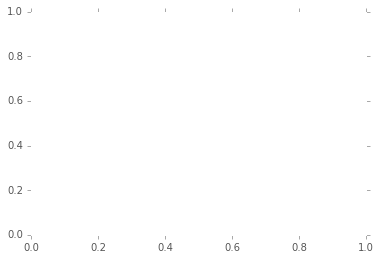

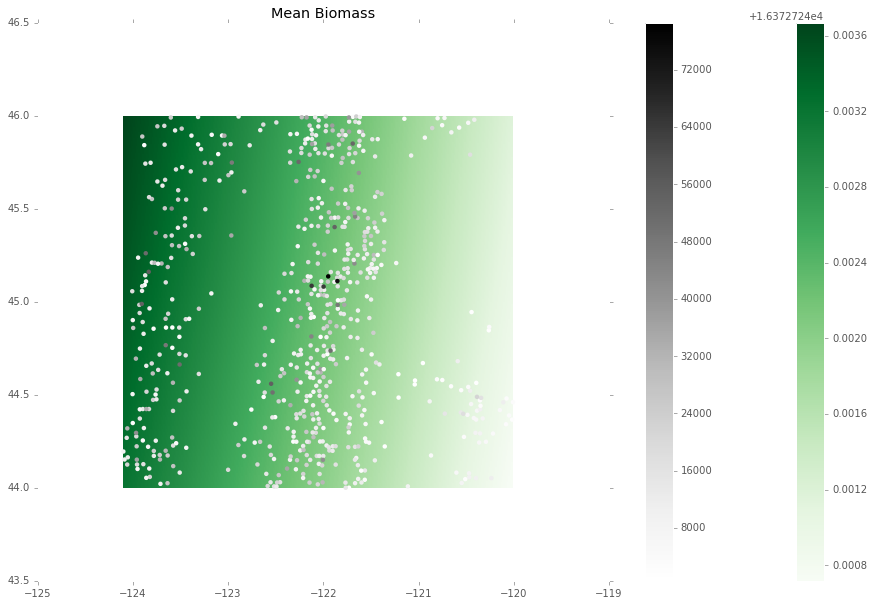

In [232]:
fig = plt.figure(figsize=(16,10), dpi= 80, facecolor='w', edgecolor='w')
plt.pcolor(Xx,Yy,means.reshape(Nn,Nn),cmap=plt.cm.Greens)
plt.colorbar()
plt.scatter(dsc.newLon,dsc.newLat,c=dsc.plotBiomass,edgecolors='',cmap=plt.cm.Greys)
plt.title("Mean Biomass")
plt.colorbar()



In [200]:
fig = plt.figure(figsize=(16,10), dpi= 80, facecolor='w', edgecolor='w')
plt.pcolor(Xx,Yy,variances.reshape(Nn,Nn),cmap=plt.cm.Blues)
plt.colorbar()
plt.scatter(nX.lon,nX.lat,c=nY,edgecolors='',cmap=plt.cm.Greys)
plt.title("Variance")
plt.colorbar()


ValueError: total size of new array must be unchanged

In [201]:
predicted_coordinates = np.vstack([data.SppN, data.lon, data.lat])

In [203]:
means,variances = model.predict_y(predicted_coordinates)

In [203]:
plt.plot(predicted_coordinates)

 ...]

KeyboardInterrupt: 

In [ ]:
ndata = pd.concat([nY,nX],axis=1)
plt.scatter(ndata.lon,ndata.lat,c=ndata.SppN)
plt.title("Species Richness")
plt.colorbar()

# With a trend function
## To do:
* Fit GLM to the trend surface
* Use the beta coeffs to create A and add it to the gaussian process.
* Make plots with Basemap

1. GLM

In [ ]:
import statsmodels.api as sm

In [ ]:
glm_binom = sm.GLM(data, data.exog, family=sm.families.Binomial())
res = glm_binom.fit()
print(res.summary())

In [ ]:
from sketches.models import Country
us = Country.objects.filter(name__contains="United States")[1]

In [ ]:
from raster_api.models import ETOPO1
from raster_api.tools import RasterData


In [ ]:
usrast = RasterData(ETOPO1,us.geom)

In [ ]:
chiqui = usrast.getRaster()

In [ ]:
usrast.display_field()

In [ ]:
usrast = RasterField